In [137]:
# needed libraries
import pandas as pd
import numpy as np
import math

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics

import random
import csv

import matplotlib.pyplot as plt

### Preparing data

Let's read our data from data.csv.

In [2]:
df = pd.read_csv("data.csv")

Before dividing data let's do preprocessing of our dataset. The task says that we have to divide the data before preprocessing, which can be arguable because we would need to apply identical modifications for different datasets and the result will be the same. It might be even wrong, specifically in removing duplications from dataset (in case we divide our data before this operation, the same rows can be in different datasets, so they will not be removed because in each dataset they are unique). 

Let's display some important info about our dataset to know what we are dealing with.

In [3]:
display(df.info())
display(df.head())
display(df.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   survived   1000 non-null   int64  
 2   pclass     1000 non-null   int64  
 3   name       1000 non-null   object 
 4   sex        1000 non-null   object 
 5   age        802 non-null    float64
 6   sibsp      1000 non-null   int64  
 7   parch      1000 non-null   int64  
 8   ticket     1000 non-null   object 
 9   fare       999 non-null    float64
 10  cabin      233 non-null    object 
 11  embarked   998 non-null    object 
 12  home.dest  566 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 101.7+ KB


None

,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9000,NaN,S,"Wiltshire, England Niagara Falls, NY"
1,1,0,3,"Jardin, Mr. Jose Neto",male,NaN,0,0,SOTON/O.Q. 3101305,7.0500,NaN,S,NaN
2,2,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9000,NaN,S,NaN
3,3,1,3,"O'Brien, Mrs. Thomas (Johanna ""Hannah"" Godfrey)",female,NaN,1,0,370365,15.5000,NaN,Q,NaN
4,4,1,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,"Greensburg, PA"


ID           1000
survived        2
pclass          3
name          999
sex             2
age            95
sibsp           7
parch           8
ticket        746
fare          254
cabin         157
embarked        3
home.dest     313
dtype: int64

Let's transform text features into numerical ones because our classification models does not work with them. Before that we need to transform these object features into categorical.

Presumably we can drop name column because it is not expected to have any direct impact on a person's likelihood of survival. Our models work with numerical features, so non-numeric columns like name need to be transformed or droped. In case we would like to transform (encode) names as unique numerical values with one-hot encoding, it could lead to a large number of features, which could worsen our future model. For the same reasons we can drop ticket and howm.dest colums. ID is just a unique value for a person, we don't need it for our models.

In [4]:
df = df.drop(["name", "ticket", "home.dest", "ID"], axis=1)

In [5]:
# changing type of sex column from object to int
df["sex"] = df["sex"].map({"male": 0, "female": 1})

We have two remaining object features - cabin and embarked.  

Let's drop cabin column first, reasons for that:

1) Feature cabin has less than 25% non-null values. 
2) On Titanic the higher status (more premium cabin) you had, the bigger propability that you would survive, this peace of information we can get from the feature fare (price for your place on board).

In [6]:
df = df.drop("cabin", axis=1)

There are just two missing values in embarked and one in fare, let's drop these rows before changing dtype.

In [7]:
df.dropna(subset=["embarked", "fare"], inplace=True)
df["embarked"] = df["embarked"].map({"C": 0, "Q": 1, "S": 2})

We have about 20% of NaN values in age, let's change them for mean value of this column, which is good option how to treat missing values.

In [8]:
df = df.fillna(df.mean())

In [9]:
# dataset after preprocessing 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 997 entries, 0 to 999
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  997 non-null    int64  
 1   pclass    997 non-null    int64  
 2   sex       997 non-null    int64  
 3   age       997 non-null    float64
 4   sibsp     997 non-null    int64  
 5   parch     997 non-null    int64  
 6   fare      997 non-null    float64
 7   embarked  997 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 70.1 KB


Now let's divide the dataset into the target variable that we want to predict and the matrix of features from which we will predict. In our case, the target variable is survived.

In [10]:
Xdata = df.drop("survived", axis = 1)
Ydata = df["survived"]

Then we divide the data into training (60%), validation (20%) and testing (20%) parts. There is no need of keeping the chronological or any other order of data, therefore for pseudorandom division of data we can use function train_test_split from sklearn. 

In [11]:
# randomly choosen seed for train_test_split
seed = random.randrange(1, 1000)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xdata, Ydata, test_size=0.4, random_state=seed)
Xval, Xtest, Yval, Ytest = train_test_split(Xtest, Ytest, test_size=0.5, random_state=seed)

### Modelling desicion tree

The decision tree algorithm can be suitable for predicting survival on the Titanic based on the provided dataset. It can handle a mix of numerical and categorical features, making them suitable for our dataset, which have a combination of integer and float features. We have to be aware of importance of hyperparameters, because their proper tuning is essential. Adjusting parameters such as the maximum depth of the tree can significantly impact the model's performance.

As hyperparametrs we can set up max_depth of our tree and criterion, which is used in calculation of information gain.

In [12]:
# results of gini criterion for different max_depths
val_gini_results = []
train_gini_results = []
# results of entropy criterion for different max_depths
val_entr_results = []
train_entr_results = []

# through depth from 1 to 25
for depth in range(1,26):
    # creating decision tree with gini criterion
    clf = DecisionTreeClassifier(max_depth=depth, criterion="gini")
    clf.fit(Xtrain, Ytrain)
    # inserting results of predictions on validation data
    val_gini_results.append(metrics.accuracy_score(Yval, clf.predict(Xval)))
    train_gini_results.append(metrics.accuracy_score(Ytrain, clf.predict(Xtrain)))
    
    # creating decision tree with entropy criterion
    clf = DecisionTreeClassifier(max_depth=depth, criterion="entropy")
    clf.fit(Xtrain, Ytrain)
    # inserting results of predictions on validation data
    val_entr_results.append(metrics.accuracy_score(Yval, clf.predict(Xval)))
    train_entr_results.append(metrics.accuracy_score(Ytrain, clf.predict(Xtrain))) 

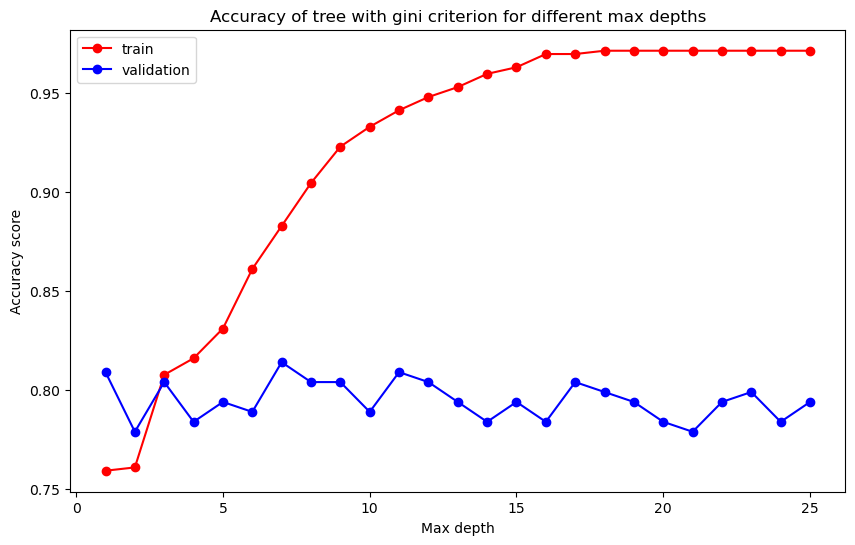

In [13]:
plt.figure(figsize=(10,6))

depths = range(1,26)

plt.plot(depths, train_gini_results, 'or-')
plt.plot(depths, val_gini_results, 'ob-')

plt.title("Accuracy of tree with gini criterion for different max depths")
plt.xlabel("Max depth")
plt.ylabel("Accuracy score")
plt.legend(['train', 'validation'])
        
plt.show()

In [41]:
best_depth_gini = val_gini_results.index(max(val_gini_results)) + 1
accuracy_gini = max(val_gini_results)
print("The highest accuracy on validation data with gini criterion has tree with max_depth = " + str(best_depth_gini))
print("Accuracy - " + str(accuracy_gini))

The highest accuracy on validation data with gini criterion has tree with max_depth = 7
Accuracy - 0.8140703517587939


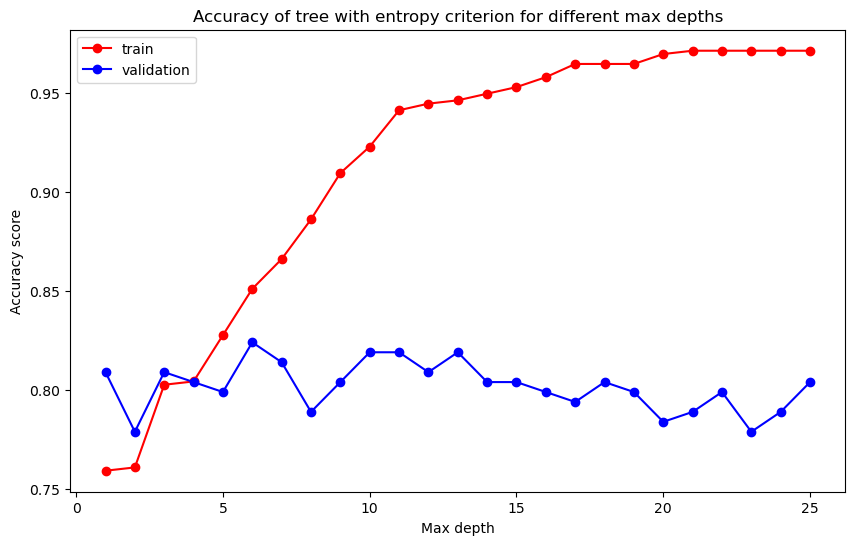

In [42]:
plt.figure(figsize=(10,6))

plt.plot(depths, train_entr_results, 'or-')
plt.plot(depths, val_entr_results, 'ob-')

plt.title("Accuracy of tree with entropy criterion for different max depths")
plt.xlabel("Max depth")
plt.ylabel("Accuracy score")
plt.legend(['train', 'validation'])
        
plt.show()

In [60]:
best_depth_entr = val_entr_results.index(max(val_entr_results)) + 1
accuracy_entr = max(val_entr_results)
print("The highest accuracy on validation data with entropy criterion has tree with max_depth = " + str(best_depth_entr))
print("Accuracy - " + str(accuracy_entr))

The highest accuracy on validation data with entropy criterion has tree with max_depth = 6
Accuracy - 0.8241206030150754


In [104]:
# choosing "best" hyperparameters
best_params_dt = {"max_depth": best_depth_entr, "criterion": "entropy"} if accuracy_entr > accuracy_gini \
            else {"max_depth": best_depth_gini, "criterion": "gini"}

print("Hyperparameters of final tree model - " + str(best_params_dt))
print()

# creating desicion tree with "the best" hyperparameters
clf_dt_final = DecisionTreeClassifier(**best_params_dt)
clf_dt_final.fit(Xtrain, Ytrain)
# predictions of validation data
final_tree_pred_val = clf_dt_final.predict(Xval)

print(f'F1 score: {metrics.f1_score(Yval, final_tree_pred_val):.4f}')

Hyperparameters of final tree model - {'max_depth': 6, 'criterion': 'entropy'}

F1 score: 0.7826


The F1 score is a metric that combines precision (the ratio of true positive predictions to the total predicted positives) and recall (the ratio of true positive predictions to the total actual positives) into a single value.  
F1 score of our mode is a decent result, it indicates a reasonable balance between precision and recall. Let's continue evalution of our model with ROC.

In [105]:
# calculating probability of our prediction on validation data
Yval_prob = clf_dt_final.predict_proba(Xval)
# getting one column (probability of 1)
Yval_prob1 = Yval_prob[:,1]

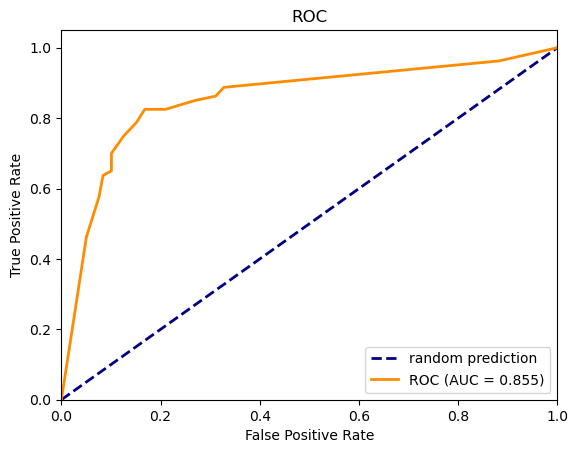

In [106]:
FPR, TPR, thresholds = metrics.roc_curve(Yval, Yval_prob1)

# calculating AUC
AUC = metrics.roc_auc_score(Yval, Yval_prob1)

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label = "random prediction")
plt.plot(FPR, TPR, color="darkorange", lw=2, label = f"ROC (AUC = {AUC:.3f})")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.title("ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

plt.show()

The ROC (Receiver Operating Characteristic) curve and the corresponding AUC (Area Under the Curve) are used to evaluate the performance of a binary classification model across different threshold values. Our result suggests that the model has a relatively good ability to distinguish between the positive and negative classes across different threshold values.  
From the visualisation we can ensure that the model is providing value beyond random chance.

### Modelling k-Nearest Neighbors

KNN is a non-parametric method that can capture complex, non-linear relationships in the data. This can be beneficial if the relationship between the features and the likelihood of survival is not well described by linear models. As desicion tree it can also handle a mix of numerical and categorical features, making it suitable for our dataset.

As hyperparametrs we can set up:

1) the main one is n_neighbors - number of observed neighbours
2) metrics - function which we use to calculate the distance between two points, there are many of them, let's limit ourselves to Euclidean and Manhattan
3) weight - uniform, this is the default option. It assigns equal weight to all neighbors. And distance, it assigns weights to neighbors based on their inverse distance. Closer neighbors have more influence on the prediction than neighbors that are farther away. 

In [20]:
# Euclidean metric
# results of uniform weight for different n_neighbors
val_euclid_uni_results = []
train_euclid_uni_results = []
# results of distance weight for different n_neighbors
val_euclid_dist_results = []
train_euclid_dist_results = []

# Manhattan metric
# results of uniform weight for different n_neighbors
val_manh_uni_results = []
train_manh_uni_results = []
# results of distance weight for different n_neighbors
val_manh_dist_results = []
train_manh_dist_results = []

# n_neighbors from 3 to 15
for k in range(3,16):
    
    clf = KNeighborsClassifier(n_neighbors = k, metric='euclidean', weights='uniform')
    clf.fit(Xtrain, Ytrain)
    val_euclid_uni_results.append(clf.score(Xval, Yval))
    train_euclid_uni_results.append(clf.score(Xtrain, Ytrain))
    
    clf = KNeighborsClassifier(n_neighbors = k, metric='euclidean', weights='distance')
    clf.fit(Xtrain, Ytrain)
    val_euclid_dist_results.append(clf.score(Xval, Yval))
    train_euclid_dist_results.append(clf.score(Xtrain, Ytrain))
    
    clf = KNeighborsClassifier(n_neighbors = k, metric='manhattan', weights='uniform')
    clf.fit(Xtrain, Ytrain)
    val_manh_uni_results.append(clf.score(Xval, Yval))
    train_manh_uni_results.append(clf.score(Xtrain, Ytrain))
    
    clf = KNeighborsClassifier(n_neighbors = k, metric='manhattan', weights='distance')
    clf.fit(Xtrain, Ytrain)
    val_manh_dist_results.append(clf.score(Xval, Yval))
    train_manh_dist_results.append(clf.score(Xtrain, Ytrain))

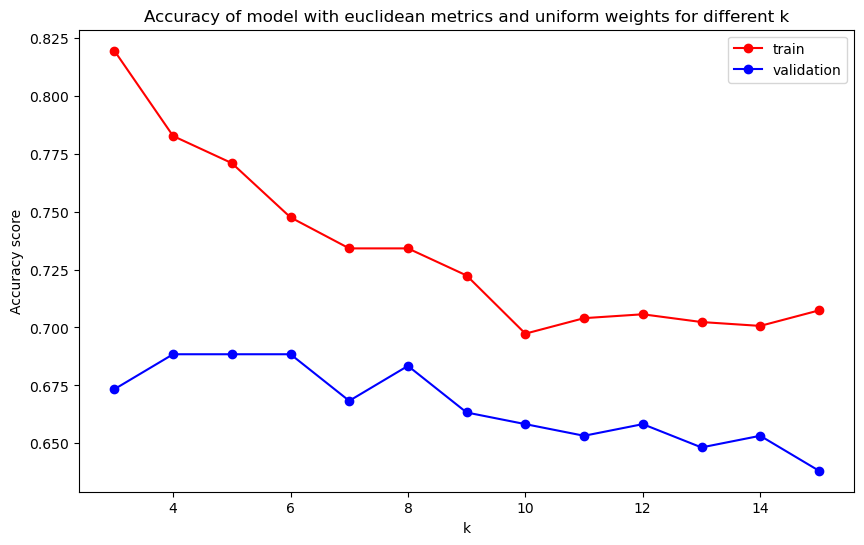

In [21]:
plt.figure(figsize=(10,6))

n_neighbors = range(3,16)

plt.plot(n_neighbors, train_euclid_uni_results, 'or-')
plt.plot(n_neighbors, val_euclid_uni_results, 'ob-')

plt.title("Accuracy of model with euclidean metrics and uniform weights for different k")
plt.xlabel("k")
plt.ylabel("Accuracy score")
plt.legend(['train', 'validation'])
        
plt.show()

In [49]:
best_depth_eucl_un = val_euclid_uni_results.index(max(val_euclid_uni_results)) + 3
accuracy_eucl_un = max(val_euclid_uni_results)
print("The highest accuracy on validation data with euclidean metrics and uniform weights has model with k = " + str(best_depth_eucl_un))
print("Accuracy - " + str(accuracy_eucl_un))

The highest accuracy on validation data with euclidean metrics and uniform weights has model with k = 4
Accuracy - 0.6884422110552764


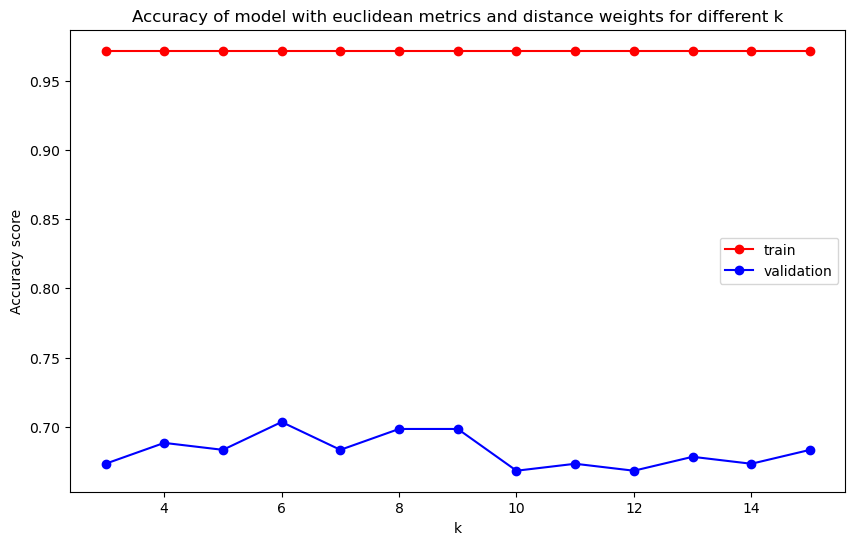

In [23]:
plt.figure(figsize=(10,6))

n_neighbors = range(3,16)

plt.plot(n_neighbors, train_euclid_dist_results, 'or-')
plt.plot(n_neighbors, val_euclid_dist_results, 'ob-')

plt.title("Accuracy of model with euclidean metrics and distance weights for different k")
plt.xlabel("k")
plt.ylabel("Accuracy score")
plt.legend(['train', 'validation'])
        
plt.show()

In [50]:
best_depth_eucl_dist = val_euclid_dist_results.index(max(val_euclid_dist_results)) + 3
accuracy_eucl_dist = max(val_euclid_dist_results)
print("The highest accuracy on validation data with euclidean metrics and distance weights has model with k = " + str(best_depth_eucl_dist))
print("Accuracy - " + str(accuracy_eucl_dist))

The highest accuracy on validation data with euclidean metrics and distance weights has model with k = 6
Accuracy - 0.7035175879396985


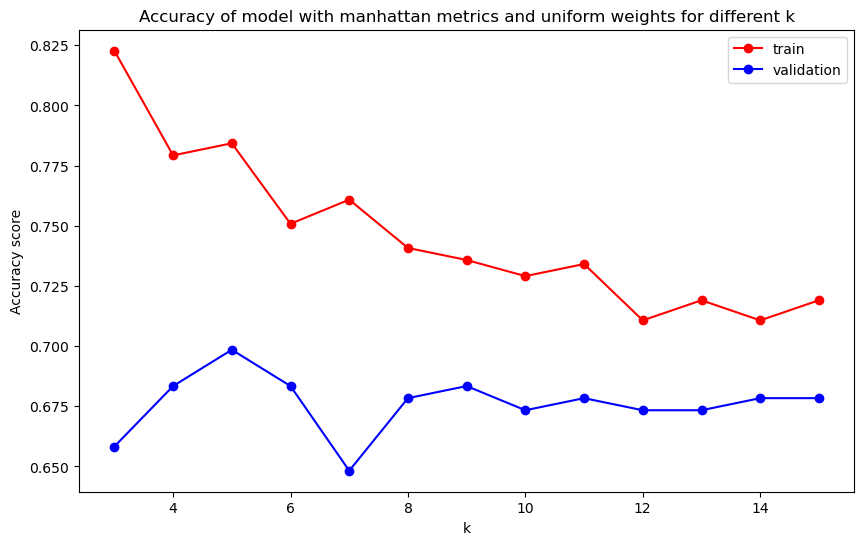

In [25]:
plt.figure(figsize=(10,6))

n_neighbors = range(3,16)

plt.plot(n_neighbors, train_manh_uni_results, 'or-')
plt.plot(n_neighbors, val_manh_uni_results, 'ob-')

plt.title("Accuracy of model with manhattan metrics and uniform weights for different k")
plt.xlabel("k")
plt.ylabel("Accuracy score")
plt.legend(['train', 'validation'])
        
plt.show()

In [51]:
best_depth_manh_un = val_manh_uni_results.index(max(val_manh_uni_results)) + 3
accuracy_manh_un = max(val_manh_uni_results)
print("The highest accuracy on validation data with manhattan metrics and uniform weights has model with k = " + str(best_depth_manh_un))
print("Accuracy - " + str(accuracy_manh_un))

The highest accuracy on validation data with manhattan metrics and uniform weights has model with k = 5
Accuracy - 0.6984924623115578


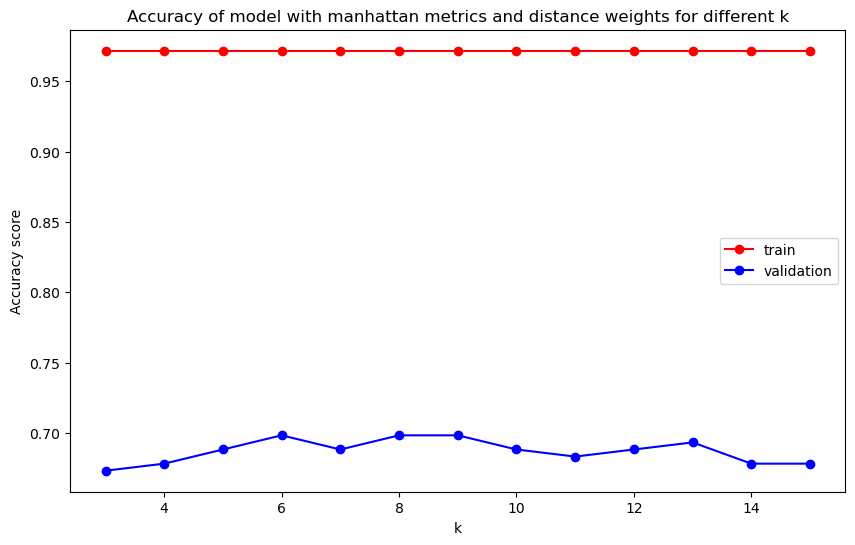

In [27]:
plt.figure(figsize=(10,6))

n_neighbors = range(3,16)

plt.plot(n_neighbors, train_manh_dist_results, 'or-')
plt.plot(n_neighbors, val_manh_dist_results, 'ob-')

plt.title("Accuracy of model with manhattan metrics and distance weights for different k")
plt.xlabel("k")
plt.ylabel("Accuracy score")
plt.legend(['train', 'validation'])
        
plt.show()

In [52]:
best_depth_manh_dist = val_manh_dist_results.index(max(val_manh_dist_results)) + 3
accuracy_manh_dist = max(val_manh_dist_results)
print("The highest accuracy on validation data with manhattan metrics and uniform weights has model with k = " + str(best_depth_manh_dist))
print("Accuracy - " + str(accuracy_manh_dist))

The highest accuracy on validation data with manhattan metrics and uniform weights has model with k = 6
Accuracy - 0.6984924623115578


In [145]:
# choosing "best" hyperparameters
params = [{accuracy_manh_dist: {"n_neighbors": best_depth_manh_dist, "metric": "manhattan", "weights": "distance"}}, \
          {accuracy_manh_un:   {"n_neighbors": best_depth_manh_un, "metric": "manhattan", "weights": "uniform"}}, \
          {accuracy_eucl_un:   {"n_neighbors": best_depth_eucl_un, "metric": "euclidean", "weights": "uniform"}}, \
          {accuracy_eucl_dist:   {"n_neighbors": best_depth_eucl_dist, "metric": "euclidean", "weights": "distance"}}]

# function to extract the accuracy from each dictionary
extract_func = lambda x: list(x.keys())[0]
# using the key parameter of max() to compare dictionaries based on accuracy
best_params_knn = list(max(params, key=extract_func).items())[0][1]

print("Hyperparameters of final knn model - " + str(best_params_knn))
print()

# creating knn model with "the best" hyperparameters
clf_knn_final = KNeighborsClassifier(**best_params_knn)
clf_knn_final.fit(Xtrain, Ytrain)
# predictions of validation data of the best knn model
final_knn_pred_val = clf.predict(Xval)

print(f'F1 score: {metrics.f1_score(Yval, final_knn_pred_val):.4f}')

Hyperparameters of final knn model - {'n_neighbors': 6, 'metric': 'euclidean', 'weights': 'distance'}

F1 score: 0.5556


F1 score of our knn model is a good result, it worse than final model of desicion tree, so from this perspective tree wins final model title.

In [54]:
# calculating probability of our prediction on validation data
Yval_prob = clf_knn_final.predict_proba(Xval)
# getting one column (probability of 1)
Yval_prob1 = Yval_prob[:,1]

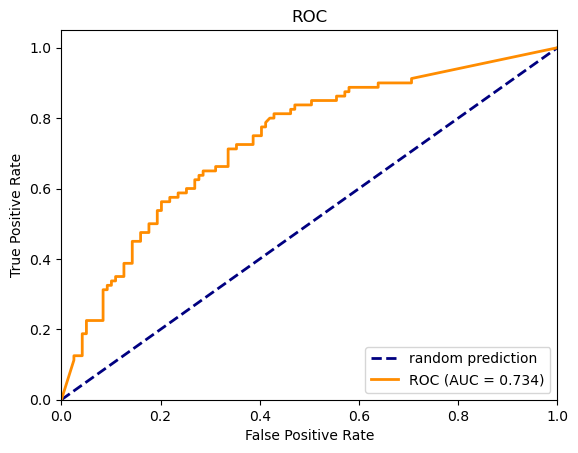

In [55]:
FPR, TPR, thresholds = metrics.roc_curve(Yval, Yval_prob1)

# calculating AUC
AUC = metrics.roc_auc_score(Yval, Yval_prob1)

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label = "random prediction")
plt.plot(FPR, TPR, color="darkorange", lw=2, label = f"ROC (AUC = {AUC:.3f})")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.title("ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

plt.show()

AUS of knn model is also lower than tree's one as well as accuracy on validation data, so our battle for the final model wins desicion tree.

### Precision of final model

In [108]:
print("accuracy score (train): {0:.6f}".format(metrics.accuracy_score(Ytrain, clf_dt_final.predict(Xtrain))))
print("accuracy score (validation): {0:.6f}".format(metrics.accuracy_score(Yval, clf_dt_final.predict(Xval))))
print("accuracy score (test): {0:.6f}".format(metrics.accuracy_score(Ytest, clf_dt_final.predict(Xtest))))

accuracy score (train): 0.851171
accuracy score (validation): 0.824121
accuracy score (test): 0.785000


The most important accuracy score is the test one, it gives us the precision, which we can expect from our model on new (unseen) data. By the way, the score is quite good.

### Prediction of evaluation.csv

Let's read data from evaluation.csv file, apply the same preproccessing modifications as we have done on data.csv, predict target variable with our final model and write predictions into results.csv file.

In [128]:
df_eval = pd.read_csv("evaluation.csv")

In [129]:
df_eval = df_eval.drop(["name", "ticket", "home.dest", "ID", "cabin"], axis=1)
df_eval["sex"] = df_eval["sex"].map({"male": 0, "female": 1})
df_eval.dropna(subset=["embarked", "fare"], inplace=True)
df_eval["embarked"] = df_eval["embarked"].map({"C": 0, "Q": 1, "S": 2})
df_eval = df_eval.fillna(df.mean())

In [138]:
# prediction
predicted_data = clf_dt_final.predict(df_eval)
# generate ID values
IDs = [i for i in range(1000, 1000 + len(predicted_data))]

result_data = zip(IDs, predicted_data)
# writing data into CSV file
with open("results.csv", 'w', newline='') as csvfile:
    fieldnames = ["ID", 'survived']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()

    for ID, survived in result_data:
        writer.writerow({'ID': ID, 'survived': survived})

In [144]:
# check up the the file with predictions
df_result = pd.read_csv("results.csv")
display(df_result.head(2))

,ID,survived
0,1000,0
1,1001,1
